In [192]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import contextily as ctx
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.transform import from_origin
from affine import Affine

# Creation of PCA Model and Determining Number of Components

In [193]:
def process_greenspace_path(ndvi_path, aqi_path, soil_moisture_path, land_temp_path):
    """
    Function to process and merge all path data per greenspace

    :param ndvi_path: Path to NDVI data
    :param aqi_path: Path to AQI data
    :param soil_moisture_path: Path to soil moisture data
    :param land_temp_path: Path to land temperature data
    :return:
    """

    ndvi_data = pd.read_csv(ndvi_path)
    aqi_data = pd.read_csv(aqi_path)
    soil_moisture_data = pd.read_csv(soil_moisture_path)
    land_temp_data = pd.read_csv(land_temp_path)

    # First merge AQI and NDVI data frames
    aqi_ndvi_merge = pd.merge(ndvi_data, aqi_data, left_index=True, right_index=True, how="inner")

    # Drop missing values
    cleaned_aqi_ndvi_merge = aqi_ndvi_merge.copy().dropna()

    # Combine coordinate and date columns
    cleaned_aqi_ndvi_merge.loc[:, 'Date'] = cleaned_aqi_ndvi_merge['Date_x'].combine_first(cleaned_aqi_ndvi_merge['Date_y'])
    cleaned_aqi_ndvi_merge.loc[:, 'Coordinates'] = cleaned_aqi_ndvi_merge['Coordinates_x'].combine_first(cleaned_aqi_ndvi_merge['Coordinates_y'])

    # Drop redundant columns
    cleaned_aqi_ndvi_merge.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    cleaned_aqi_ndvi_merge.rename(columns={'Value_x': 'NDVI', 'Value_y': 'AQI'}, inplace=True)

    # Merge soil moisture and land temp dataframes
    soil_moisture_land_temp_merge = pd.merge(soil_moisture_data, land_temp_data, left_index=True, right_index=True, how="inner")

    # Drop missing values
    cleaned_soil_moisture_land_temp_merge = soil_moisture_land_temp_merge.copy().dropna()

    # Combine coordinate and date columns
    cleaned_soil_moisture_land_temp_merge.loc[:, 'Date'] = cleaned_soil_moisture_land_temp_merge['Date_x'].combine_first(cleaned_soil_moisture_land_temp_merge['Date_y'])
    cleaned_soil_moisture_land_temp_merge.loc[:, 'Coordinates'] = cleaned_soil_moisture_land_temp_merge['Coordinates_x'].combine_first(cleaned_soil_moisture_land_temp_merge['Coordinates_y'])

    # Drop redundant columns
    cleaned_soil_moisture_land_temp_merge.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    cleaned_soil_moisture_land_temp_merge.rename(columns={'Value_x': 'Soil_Moisture', 'Value_y': 'Land_Temp'}, inplace=True)

    # Merge two dataframes together
    final_merged_data = pd.merge(cleaned_aqi_ndvi_merge, cleaned_soil_moisture_land_temp_merge, left_index=True, right_index=True, how="inner")

    # Drop missing values
    cleaned_final_merged = final_merged_data.copy().dropna()

    # Combine coordinate and date columns
    cleaned_final_merged.loc[:, 'Date'] = final_merged_data['Date_x'].combine_first(final_merged_data['Date_y'])
    cleaned_final_merged.loc[:, 'Coordinates'] = final_merged_data['Coordinates_x'].combine_first(final_merged_data['Coordinates_y'])

    # Drop redundant columns
    cleaned_final_merged.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Apply cumulative cut on NDVI to remove outliers
    ndvi_data = cleaned_final_merged['NDVI'].copy()
    sorted_ndvi_data = ndvi_data.sort_values().reset_index(drop=True)

    # Calculate cumulative percentages
    cumulative_percentage = sorted_ndvi_data.rank(pct=True)

    # Define cut-off range
    lower_cut = 0.02
    upper_cut = 0.98

    # Filter NDVI values within range
    filtered_NDVI_data = sorted_ndvi_data[
        (cumulative_percentage >= lower_cut) &
        (cumulative_percentage <= upper_cut)
        ]

    # Set lower and upper values for NDVI
    lower_cut_value = filtered_NDVI_data.min()
    upper_cut_value = filtered_NDVI_data.max()

    # Keep NDVI rows where NDVI value is within range
    cleaned_final_merged_cut = cleaned_final_merged[
        (cleaned_final_merged['NDVI'] >= lower_cut_value) &
        (cleaned_final_merged['NDVI'] <= upper_cut_value)
        ]

    return cleaned_final_merged_cut

In [194]:
# Data dictionary containing all paths per greenspace
greespace_files = {
    "Vondelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Vondelpark/Vondel_AirQualityIndex/Vondel_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Vondelpark/Vondel_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Vondelpark/Vondel_LandTemp_csv.csv",
    },
    "Westerpark": {
        "NDVI": "Datasets/Sentinel-2/Wester_NDVI/Wester_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Westerpark/Wester_AirQualityIndex/Wester_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Westerpark/Wester_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Westerpark/Wester_LandTemp_csv.csv",
    },
    "Amstelpark": {
        "NDVI": "Datasets/Sentinel-2/Amstel_NDVI/Amstel_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Amstelpark/Amstel_AirQualityIndex/Amstel_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Amstelpark/Amstel_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Amstelpark/Amstel_LandTemp_csv.csv",
    },
    "Rembrandtpark": {
        "NDVI": "Datasets/Sentinel-2/Rembrandt_NDVI/Rembrandt_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Rembrandtpark/Rembrandt_AirQualityIndex/Rembrandt_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Rembrandtpark/Rembrandt_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Rembrandtpark/Rembrandt_LandTemp_csv.csv",
    },
    "AMS": {
        "NDVI": "Datasets/Sentinel-2/AMS_NDVI/AMS_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/AMS/AMS_AirQualityIndex/AMS_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/AMS/AMS_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/AMS/AMS_LandTemp_csv.csv",
    }
}

In [195]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces = {}
for park, paths in greespace_files.items():
    greenspaces[park] = process_greenspace_path(paths["NDVI"], paths["AQI"], paths['soil_moisture'], paths['land_temp'])

In [196]:
def pca_on_greenspace(greenspaces, components):
    """
    Function to perform PCA on each green space

    :param greenspace: Dictionary of green space data
    :return:
    """

    pca_results = {}

    for park, dataframe in greenspaces.items():

        # Select relevant columns for PCA
        features = ['NDVI', 'AQI', 'Soil_Moisture', 'Land_Temp']
        features_df = dataframe[features]

        # Standardize data with mean 0 and SD 1 due to PCA being sensitive to scale
        scaler = StandardScaler()
        scaled_data =  scaler.fit_transform(features_df)

        # Apply PCA
        pca_model = PCA(n_components=components)
        principal_components = pca_model.fit_transform(scaled_data)

        # Store results in dictionary
        pca_results[park] = {
            'principal_components': principal_components,
            'explained_variance': pca_model.explained_variance_ratio_,
            'pca_model': pca_model
        }

        # Print variance explained by each component
        print(f"PCA for {park}:")
        print(f"Explained Variance Ratio: {pca_model.explained_variance_ratio_}")

        # Convert PCA results back to DataFrame for further analysis
        if components == 4:
            pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
        elif components == 3:
            pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

        pca_results[park]['pca_df'] = pca_df


    return pca_results

pca_results = pca_on_greenspace(greenspaces, 4)

PCA for Vondelpark:
Explained Variance Ratio: [0.54934018 0.2519505  0.15384184 0.04486748]
PCA for Westerpark:
Explained Variance Ratio: [0.5418355  0.25138261 0.13785596 0.06892594]
PCA for Amstelpark:
Explained Variance Ratio: [0.56683513 0.2338745  0.16136887 0.0379215 ]
PCA for Rembrandtpark:
Explained Variance Ratio: [0.58262685 0.25053519 0.11929271 0.04754525]
PCA for AMS:
Explained Variance Ratio: [0.39241545 0.25130763 0.23807728 0.11819963]


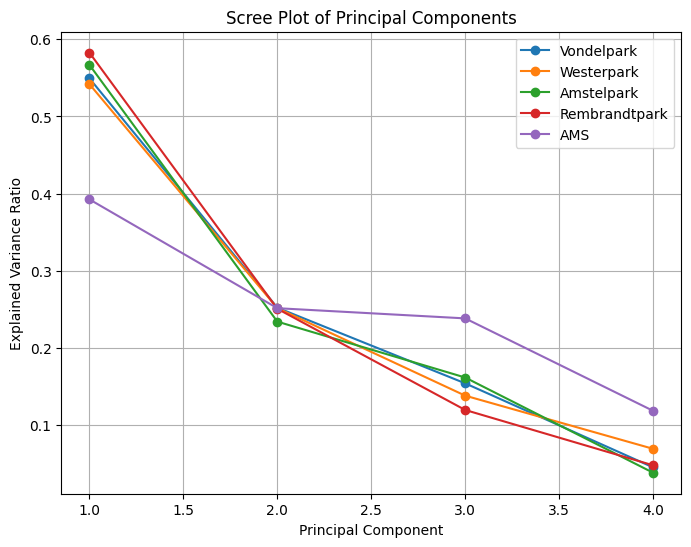

In [197]:
# Function to plot scree plot
def plot_scree(pca_results):
    plt.figure(figsize=(8, 6))

    for park, results in pca_results.items():
        explained_variance = results['pca_model'].explained_variance_ratio_
        components = np.arange(1, len(explained_variance) + 1)

        plt.plot(components, explained_variance, marker='o', label=park)

    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot of Principal Components')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function with your PCA results
plot_scree(pca_results)

Looking at the attained results along with the above scree plot, it is appropriate to retain 3 principal components as these capture 87%-95% of the total variance. Adding the fourth component would add little additional information at the cost of making the model more complicated

# Creation of Custom Index

In [198]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces_index = {}
for park, paths in greespace_files.items():
    greenspaces_index[park] = process_greenspace_path(paths["NDVI"], paths["AQI"], paths['soil_moisture'], paths['land_temp'])

In [199]:
def apply_weights(dataframe, weights):
    """
    Function to apply weights to factors

    :param dataframe:
    :param weights:
    :return:
    """
    weighted_df = dataframe.copy()
    for factor, weight in weights.items():
        if factor in dataframe.columns:
            weighted_df[factor] *= weight

    return weighted_df

# Exporting Index to GeoTIFF

In [236]:
def export_greenspace_to_geotiff(greenspaces_with_index, output_directory):
    """
    Function to export greenspaces to GeoTiff using custom index as value

    :param greenspaces_with_index: Dictionary containing greenspace dataframes with index
    :param output_directory:
    :return:
    """

    for park, dataframe in greenspaces_with_index.items():
        # Convert coordinates to float values
        dataframe[['X', 'Y']] = dataframe['Coordinates'].str.split(',', expand=True).astype(float)
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])

        # Establish row index to keep data aligned
        dataframe['Row_Index'] = dataframe.index

        # Group by unique months and export each month as a separate GeoTIFF
        unique_months = dataframe['Date'].dt.to_period('M').unique()

        for month in unique_months:
            month_data = dataframe[dataframe['Date'].dt.to_period('M') == month]

            # Save monthly data as CSV for verification
            csv_output_path = f"{output_directory}/CSV_Files/{park}_{month}.csv"
            month_data.to_csv(csv_output_path, index=False)
            print(f"CSV saved for {park} - {month}: {csv_output_path}")

            # Create pivot table for spatial representation on a grid
            pivot_table = month_data.pivot(index = 'X', columns = 'Y', values = 'Custom_Index')

            # Convert to numpy array
            greenspace_array = pivot_table.to_numpy()

            if greenspace_array is None or greenspace_array.size == 0:
                print(f"Skipping {park} for {month} due to empty data")
                continue

            # Ensure X and Y coordinates are sorted correctly
            y_coords = np.sort(pivot_table.columns.values)
            x_coords = np.sort(pivot_table.index.values)

            # Define raster transformation
            transform = from_origin(
                x_coords.min(),  # Upper-left X coordinate
                y_coords.min(),  # Upper-left Y coordinate
                abs(x_coords[1] - x_coords[0]),  # X resolution
                abs(y_coords[1] - y_coords[0]) # Y resolution
            )

            # Add 90-degree rotation
            transform = transform * Affine.rotation(-90)

            # Output file path
            output_path = f"{output_directory}/{park}_{month}.tif"

            # Write to GeoTIFF
            with rasterio.open(
                    output_path, 'w',
                    driver = 'GTiff',
                    height = greenspace_array.shape[0],
                    width = greenspace_array.shape[1],
                    count = 1,
                    dtype = greenspace_array.dtype,
                    crs= "EPSG:32631",  # Using system UTM 31U
                    transform = transform
            ) as dst:
                dst.write(greenspace_array, 1)

            print(f"GeoTIFF saved for {park} - {month}: {output_path}")

CSV saved for Vondelpark - 2024-03: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-03.csv
GeoTIFF saved for Vondelpark - 2024-03: Datasets/CustomIndex/Vondelpark_2024-03.tif
CSV saved for Vondelpark - 2024-02: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-02.csv
GeoTIFF saved for Vondelpark - 2024-02: Datasets/CustomIndex/Vondelpark_2024-02.tif
CSV saved for Vondelpark - 2024-04: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-04.csv
GeoTIFF saved for Vondelpark - 2024-04: Datasets/CustomIndex/Vondelpark_2024-04.tif
CSV saved for Vondelpark - 2024-05: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-05.csv
GeoTIFF saved for Vondelpark - 2024-05: Datasets/CustomIndex/Vondelpark_2024-05.tif
CSV saved for Vondelpark - 2024-07: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-07.csv
GeoTIFF saved for Vondelpark - 2024-07: Datasets/CustomIndex/Vondelpark_2024-07.tif
CSV saved for Vondelpark - 2024-06: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-06.csv
GeoTIFF saved for Vondelpark - 2024-06: 

In [233]:
def pca_custom_index_global(greenspaces, weights, global_scaling=True, exclude="AMS"):
    """
    Function to apply pca model to create custom index by making use of different environmental variables

    :param exclude: Area to be excluded from global scaling, in this case AMS
    :param greenspaces: Dictionary containing file paths to environmental variables per greenspace
    :param weights: Weights to apply to different environmental variables
    :param global_scaling: Option to scale index globally across all parks and months
    :return: Updated greenspaces with custom index
    """

    all_custom_indices = []

    for park, df in greenspaces.items():

        # Extract month and year from data column
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df['Month'] = df['Date'].dt.month
            df['Year'] = df['Date'].dt.year

        # Select relevant columns for PCA
        features = ['NDVI', 'AQI', 'Soil_Moisture', 'Land_Temp']
        features_df = df[features]

        # Standardize data with mean 0 and SD 1 due to PCA being sensitive to scale
        scaler = StandardScaler()
        scaled_data =  scaler.fit_transform(features_df)

        # Convert scaled data back to DataFrame
        scaled_df = pd.DataFrame(scaled_data, columns=features)

        # Apply weights to factors after standardizing
        weighted_df = apply_weights(scaled_df, weights)

        # Perform PCA with 3 components
        pca_model = PCA(n_components=3)
        principal_components = pca_model.fit_transform(weighted_df)

        # Store results
        pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

        # Compute the custom index using the principal components
        pca_df['CustomIndex'] = (
                pca_df['PC1'] * pca_model.explained_variance_ratio_[0] +
                pca_df['PC2'] * pca_model.explained_variance_ratio_[1] +
                pca_df['PC3'] * pca_model.explained_variance_ratio_[2]
        )

        # Store custom index to calculate global normalization later
        df['CustomIndex'] = pca_df['CustomIndex']
        # Put all indices together for global scaling, apart from AMS
        if exclude.lower() not in park.lower():
            all_custom_indices.append(df['CustomIndex'])

        # Save index back to the park dataframe
        greenspaces[park] = df

    all_custom_indices_df = pd.concat(all_custom_indices)

    # Determine scaling parameters globally/ based on benchmark period
    global_min_val = all_custom_indices_df.values.min()
    global_max_val = all_custom_indices_df.values.max()

    for park, df in greenspaces.items():
        # Scale custom index globally to range 1-100 for greenspaces
        if exclude.lower() not in park.lower():
            df['CustomIndex_Scaled'] = ((df['CustomIndex'] - global_min_val) / (global_max_val - global_min_val)) * (100 - 1) + 1
        else:
            # Apply local scaling for AMS
            local_min = df['CustomIndex'].min()
            local_max = df['CustomIndex'].max()
            df['CustomIndex_Scaled'] = ((df['CustomIndex'] - local_min) / (local_max - local_min)) * (100 - 1) + 1

        # Drop any existing 'Custom_Index' and add new scaled index
        df.drop(columns=['Custom_Index'], errors='ignore', inplace=True)
        df = df.reset_index(drop=True)
        df['Custom_Index'] = df['CustomIndex_Scaled']

        greenspaces[park] = df

        print(f"Index calculated and applied to {park}")

    return greenspaces

In [234]:
# Set weights according to correlation and literature
weights = {
    'NDVI': 0.30,
    'Land_Temp': 0.45,
    'Soil_Moisture': 0.15,
    'AQI': 0.1
}

pca_results = pca_custom_index_global(greenspaces, weights)
export_greenspace_to_geotiff(pca_results, 'Datasets/CustomIndex')

Index calculated and applied to Vondelpark
Index calculated and applied to Westerpark
Index calculated and applied to Amstelpark
Index calculated and applied to Rembrandtpark
Index calculated and applied to AMS
CSV saved for Vondelpark - 2024-03: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-03.csv
GeoTIFF saved for Vondelpark - 2024-03: Datasets/CustomIndex/Vondelpark_2024-03.tif
CSV saved for Vondelpark - 2024-02: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-02.csv
GeoTIFF saved for Vondelpark - 2024-02: Datasets/CustomIndex/Vondelpark_2024-02.tif
CSV saved for Vondelpark - 2024-04: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-04.csv
GeoTIFF saved for Vondelpark - 2024-04: Datasets/CustomIndex/Vondelpark_2024-04.tif
CSV saved for Vondelpark - 2024-05: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-05.csv
GeoTIFF saved for Vondelpark - 2024-05: Datasets/CustomIndex/Vondelpark_2024-05.tif
CSV saved for Vondelpark - 2024-07: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-07.csv
Geo